In [1]:
import json
import math
import numpy as pd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

In [2]:
data = pd.read_csv('data/train.csv', parse_dates=['Date'])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22536 entries, 0 to 22535
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            22536 non-null  datetime64[ns]
 1   ConfirmedCases  22536 non-null  float64       
 2   name            22536 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 528.3+ KB


In [4]:
data.head()

,Date,ConfirmedCases,name
0,2020-01-22,0.000,Afghanistan_
1,2020-01-23,0.000,Afghanistan_
2,2020-01-24,0.000,Afghanistan_
3,2020-01-25,0.000,Afghanistan_
4,2020-01-26,0.000,Afghanistan_


In [5]:
freq = '1D'
id_feature = 'name'
label_feature = 'ConfirmedCases'
time_feature = 'Date'
sparse_features = []
dynamic_dense_features = []
start_time = data[time_feature].min()
end_time = data[time_feature].max()
print('start_time:', start_time)
print('end_time:', end_time)

start_time: 2020-01-22 00:00:00
end_time: 2020-04-02 00:00:00


In [6]:
def get_timeseries(df, dense_feature):
    timeseries = []
    df_group = df.groupby([id_feature])
    for name, group in df_group:
        tmp_df = pd.DataFrame({name: group[dense_feature], time_feature:group[time_feature]})
        tmp_df.set_index(time_feature, inplace=True)
        if dense_feature == id_feature:
            tmp_df = tmp_df.resample(freq).mean()
        else:
            tmp_df = tmp_df.resample(freq).mean()
#         print(tmp_df)
        timeseries.append(tmp_df[name])
#     print(timeseries)
    return timeseries

In [7]:
def visualize_timeseries(timeseries, dense_feature):
    row_num = math.ceil(len(timeseries)/2)
    fig, axs = plt.subplots(min(row_num, 2), 2, figsize=(20, 20), sharex=True)
    axx = axs.ravel()
    for i in range(0, min(len(timeseries), 4)):
        timeseries[i].plot(ax=axx[i])
        axx[i].set_xlabel("date")
        axx[i].set_ylabel(dense_feature)
        axx[i].grid(which='minor', axis='x')

In [8]:
def save_timeseries(timeseries, filename):
    with open(filename, 'wb') as fp:
        data = [
            {
                "start": str(timeseries[i].index[0]),
                "target": timeseries[i].tolist()
            }
            for i in range(len(timeseries))
        ]
        for d in data:
            fp.write(json.dumps(d).replace('NaN', '"NaN"').encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [9]:
!mkdir -p output

CPU times: user 1.15 s, sys: 11.2 ms, total: 1.17 s
Wall time: 1.16 s


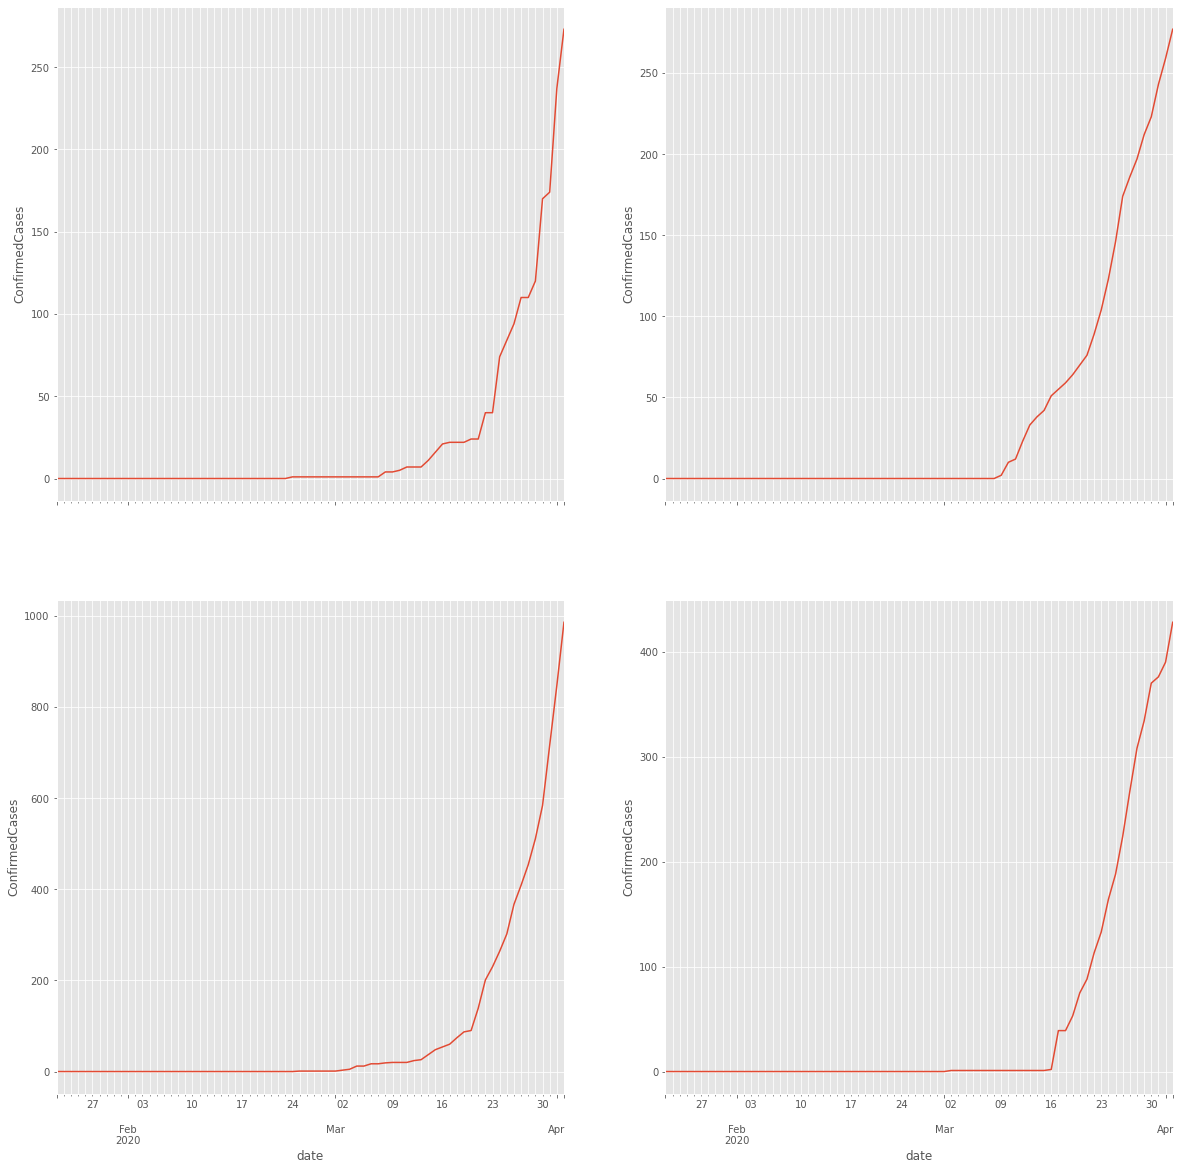

In [10]:
%%time

data_timeseries = get_timeseries(data, label_feature)
visualize_timeseries(data_timeseries, label_feature)
save_timeseries(data_timeseries, 'output/'+label_feature+'.json')

In [11]:
DATETIME_START_OF_TRAIN = "2020-01-22 00:00:00"
DATETIME_END_OF_TRAIN = "2020-03-29 00:00:00"
DATETIME_START_OF_TEST = DATETIME_END_OF_TRAIN
DATETIME_END_OF_TEST = "2020-04-03 00:00:00"

freq = '1D'
prediction_length = 5
context_length = prediction_length*10

In [12]:
start_dataset = pd.Timestamp(DATETIME_START_OF_TRAIN, freq=freq)
end_training = pd.Timestamp(DATETIME_END_OF_TRAIN, freq=freq)
start_test = pd.Timestamp(DATETIME_START_OF_TEST, freq=freq)
end_test = pd.Timestamp(DATETIME_END_OF_TEST, freq=freq)
print('start_dataset:', start_dataset)
print('end_training:', end_training)
print('start_test:', start_test)
print('end_test:', end_test)

start_dataset: 2020-01-22 00:00:00
end_training: 2020-03-29 00:00:00
start_test: 2020-03-29 00:00:00
end_test: 2020-04-03 00:00:00


In [13]:
max_length = 0
if freq == '1Min':
    max_length = (end_test-start_dataset).days*24*60
elif freq == '1H':
    max_length = (end_test-start_dataset).days*24
elif freq == '1D':
    max_length = (end_test-start_dataset).days
elif freq == '1M':
    year1 = start_dataset.year
    month1 = start_dataset.month
    year2 = end_test.year
    month2 = end_test.month
    max_length = (year2-year1)*12+(month2-month1)
print('max_length:', max_length)

max_length: 72


In [14]:
%%time

ids = []
data_group = data.groupby(id_feature)
cnt = 0
for name, group in data_group:
    if cnt % 1000 == 0:
        print('cnt:', cnt)
    cnt += 1
    # print(name)
    # print(group)
    new_name = str(name)
    # print(new_name)
    ids.append(new_name)

num_timeseries = len(ids)
print('num_timeseries:', num_timeseries)

cnt: 0
num_timeseries: 313
CPU times: user 6.43 ms, sys: 3.04 ms, total: 9.46 ms
Wall time: 9.02 ms


In [15]:
training_data = [
    {
        "start": str(data_timeseries[i].index[0]),
        "target": data_timeseries[i][start_dataset:end_training][:-1].tolist(),  # We use -1, because pandas indexing includes the upper bound 
#         "dynamic_feat": [],
#         "cat": [],
        "id": ids[i]
    }
    for i in range(num_timeseries)
]
print(len(training_data), len(data_timeseries[0][start_dataset:end_training][:-1].tolist()))

313 67


In [16]:
test_data = [
    {
        "start": str(data_timeseries[i].index[0]),
        "target": data_timeseries[i][start_dataset:end_test][:-1].tolist(),  # We use -1, because pandas indexing includes the upper bound 
#         "dynamic_feat": [],
#         "cat": [],
        "id": ids[i]
    }
    for i in range(num_timeseries)
]
print(len(test_data), len(data_timeseries[0][start_dataset:end_test][:-1].tolist()))

313 71


In [17]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).replace('NaN', '"NaN"').encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [18]:
%%time
write_dicts_to_file("data/train_"+freq+".json", training_data)
write_dicts_to_file("data/test_"+freq+".json", test_data)

CPU times: user 11.2 ms, sys: 232 µs, total: 11.4 ms
Wall time: 10.6 ms
